In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import polars as pl

from collections import Counter
from scipy.stats import ttest_ind, chi2_contingency

%reload_ext autoreload
%autoreload 2

In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
df_merchants = pl.read_csv("../datasets/merchants.csv").cast({i: pl.Categorical for i in ["merchant_id", "category", "country"]})
df_merchants = df_merchants.rename({i: f"{i}_merchant" for i in df_merchants.columns[1:]})

cat_columns = {i: pl.Categorical for i in ["user_id", "education", "sex", "primary_source_of_income", "country"]}
df_users = pl.read_csv("../datasets/users.csv", try_parse_dates=True).cast(cat_columns)
df_users = df_users.rename({i: f"{i}_user" for i in df_users.columns[1:]})

cat_columns = {i: pl.Categorical for i in ["user_id", "merchant_id", "channel", "currency", "device", "payment_method"]}
date_columns = {i: pl.Datetime for i in ["timestamp"]}
df_transactions = pl.read_ndjson("../datasets/transactions.json").cast(cat_columns | date_columns).unnest("location")

df_full = df_transactions.join(df_users, on="user_id", how="left").join(df_merchants, on="merchant_id", how="left").sort("timestamp")

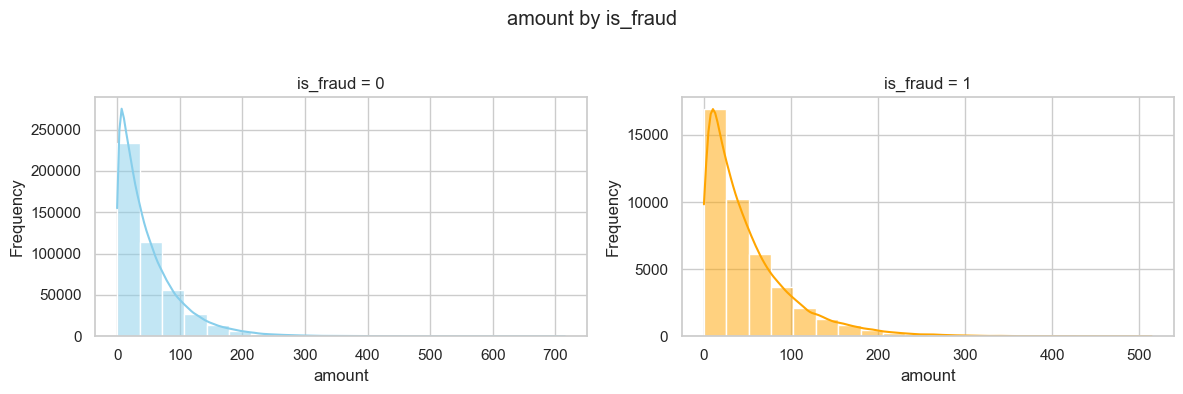

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,amount,continuous,49.88,34.52,49.96
1,amount,continuous,50.28,34.88,50.27


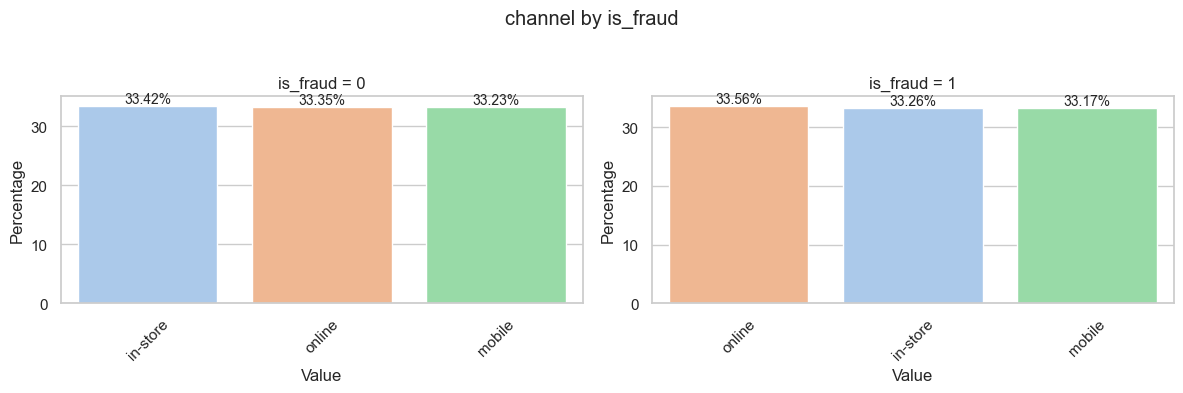

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,channel,discrete,in-store,33.42
1,channel,discrete,online,33.56


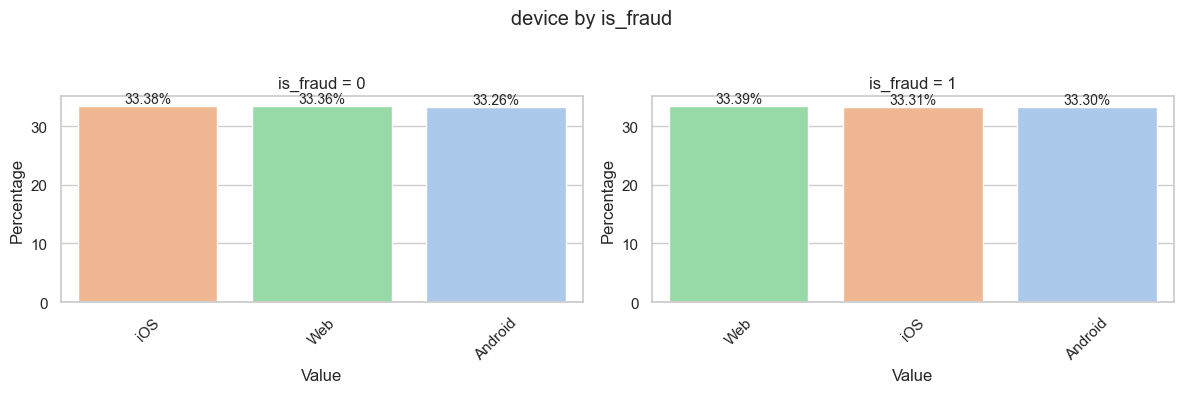

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,device,discrete,iOS,33.38
1,device,discrete,Web,33.39


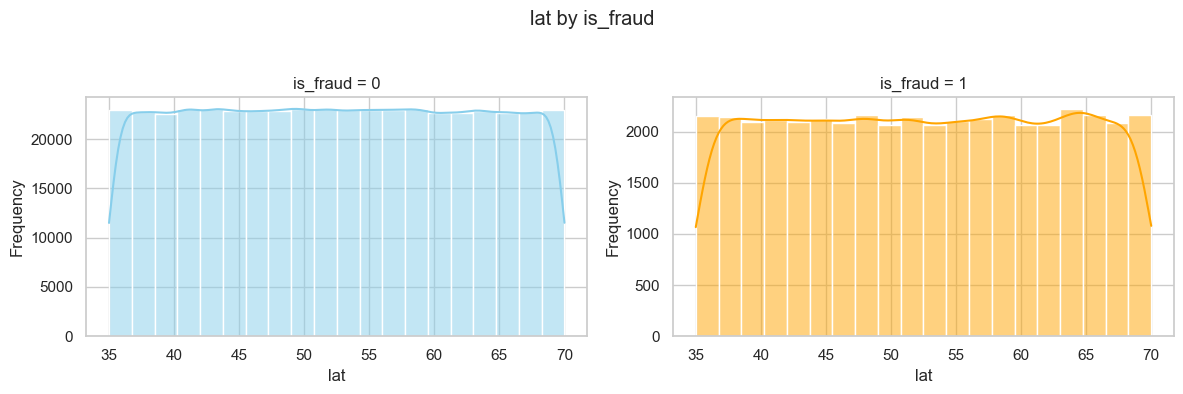

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,lat,continuous,52.49,52.48,10.09
1,lat,continuous,52.52,52.51,10.13


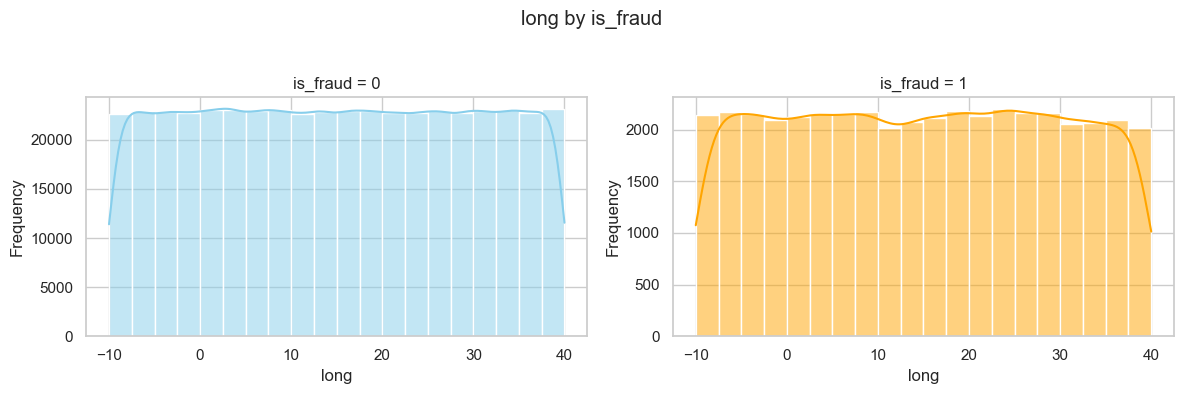

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,long,continuous,15.01,15.01,14.44
1,long,continuous,14.88,14.96,14.39


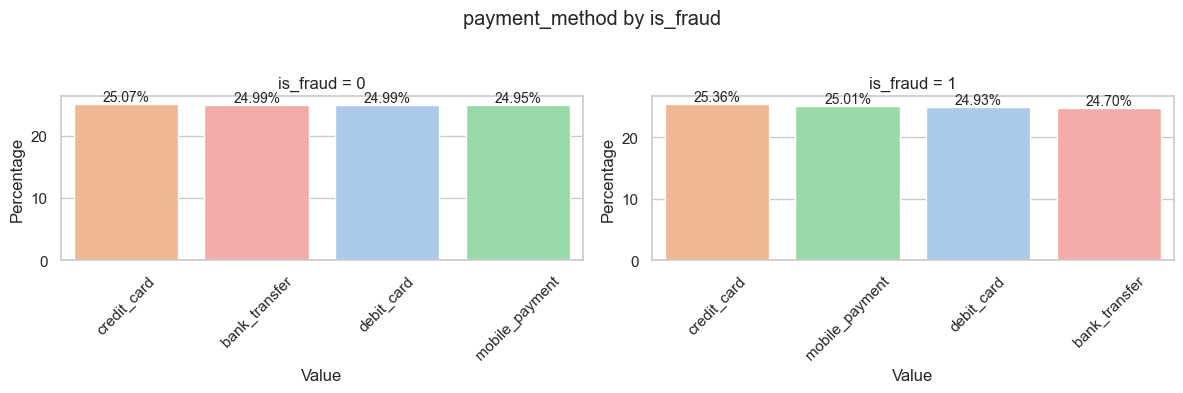

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,payment_method,discrete,credit_card,25.07
1,payment_method,discrete,credit_card,25.36


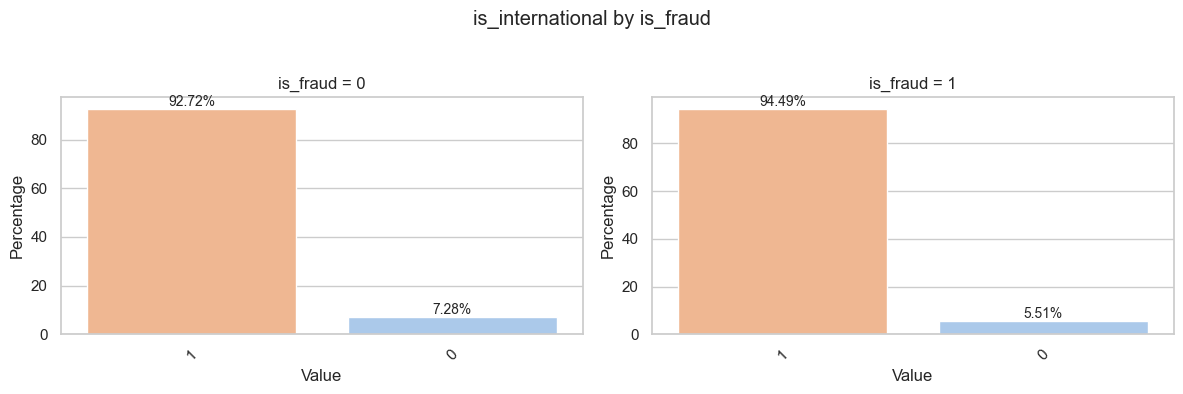

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,is_international,discrete,1,92.72
1,is_international,discrete,1,94.49


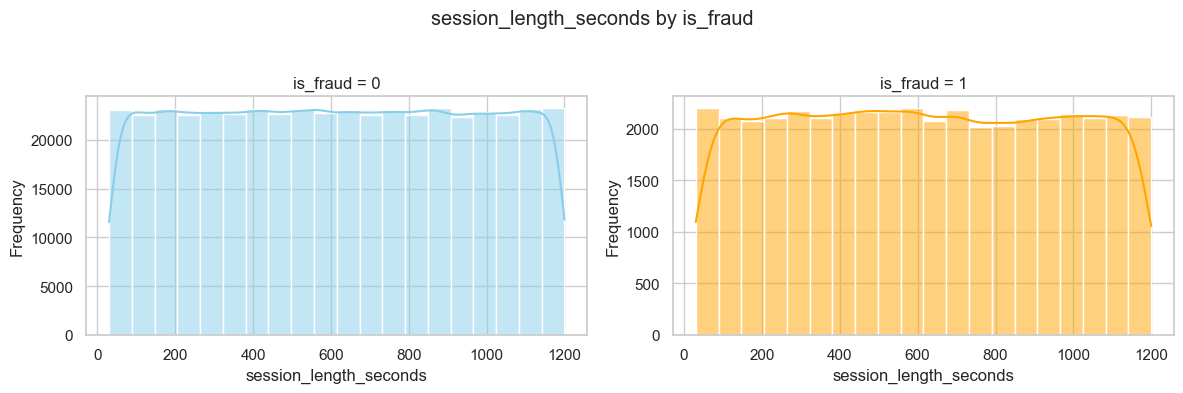

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,session_length_seconds,continuous,615.19,615.0,338.09
1,session_length_seconds,continuous,612.79,608.0,338.05


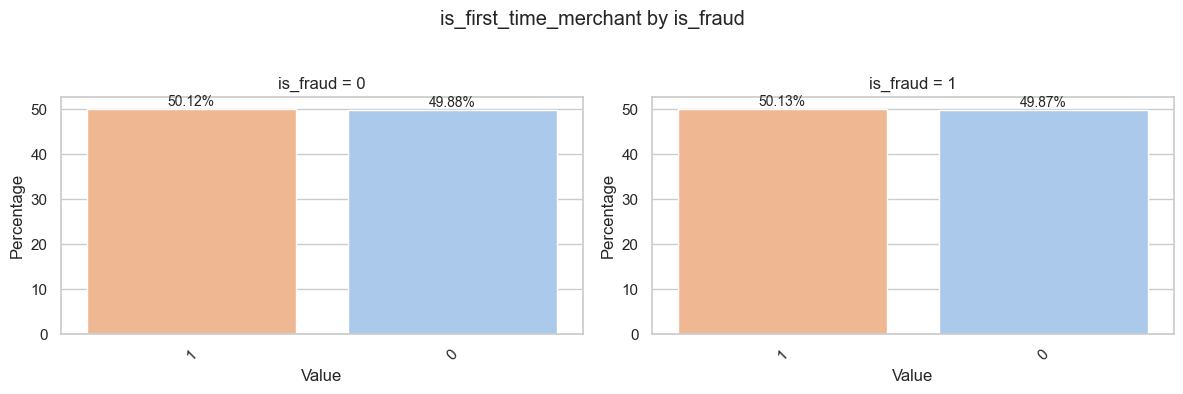

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,is_first_time_merchant,discrete,1,50.12
1,is_first_time_merchant,discrete,1,50.13


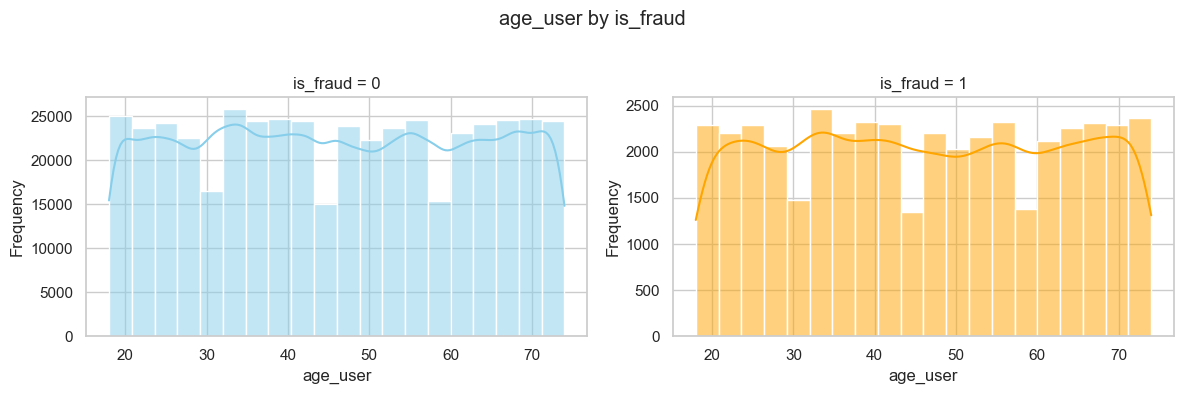

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,age_user,continuous,45.94,46.0,16.52
1,age_user,continuous,46.03,46.0,16.57


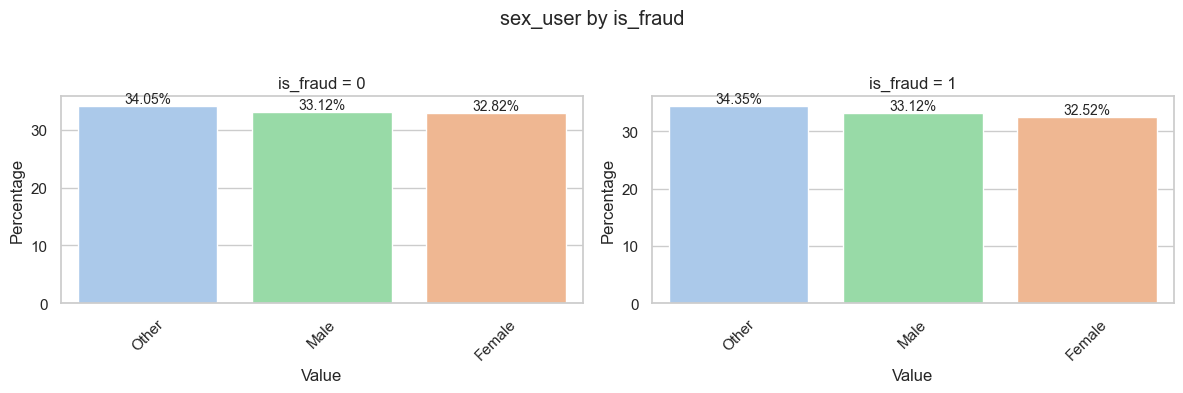

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,sex_user,discrete,Other,34.05
1,sex_user,discrete,Other,34.35


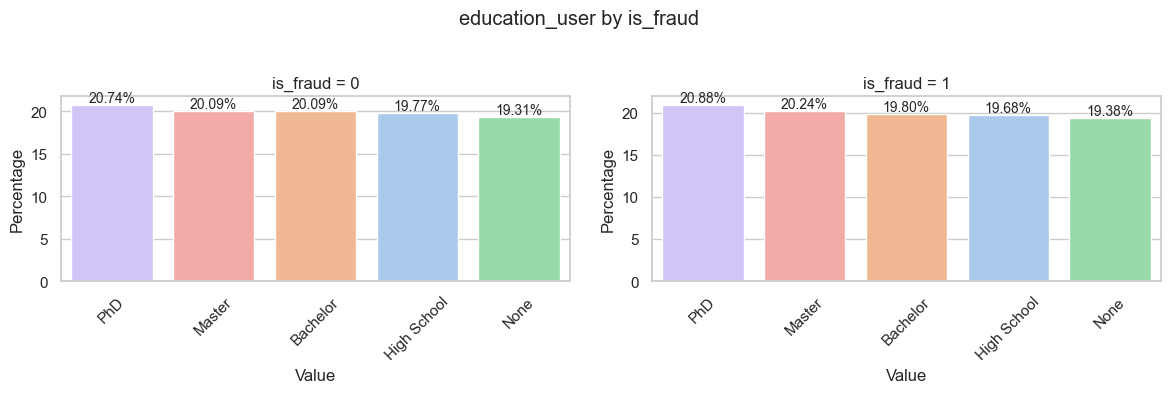

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,education_user,discrete,PhD,20.74
1,education_user,discrete,PhD,20.88


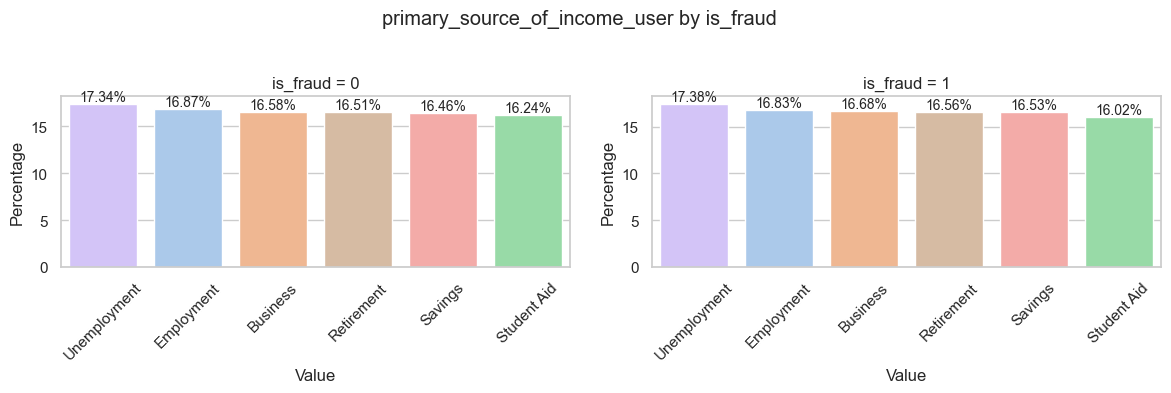

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,primary_source_of_income_user,discrete,Unemployment,17.34
1,primary_source_of_income_user,discrete,Unemployment,17.38


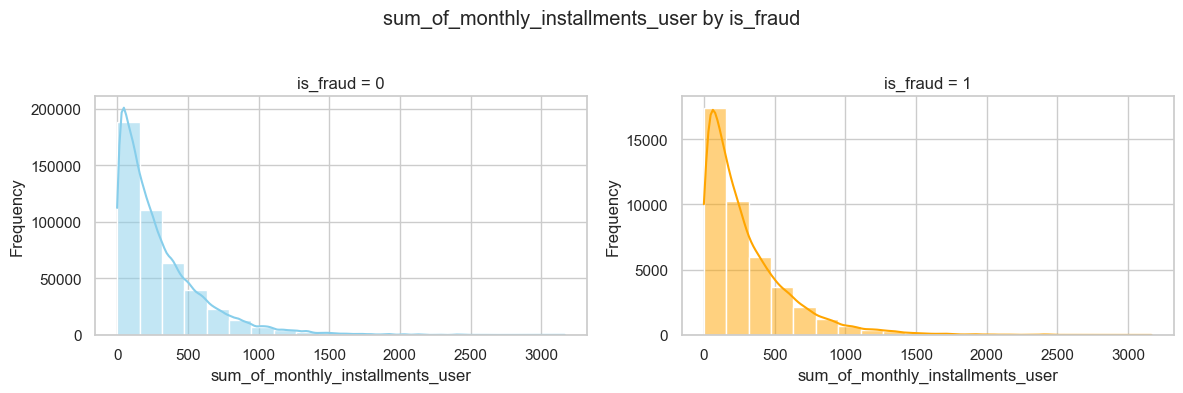

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,sum_of_monthly_installments_user,continuous,301.38,207.33,303.56
1,sum_of_monthly_installments_user,continuous,301.04,207.33,302.98


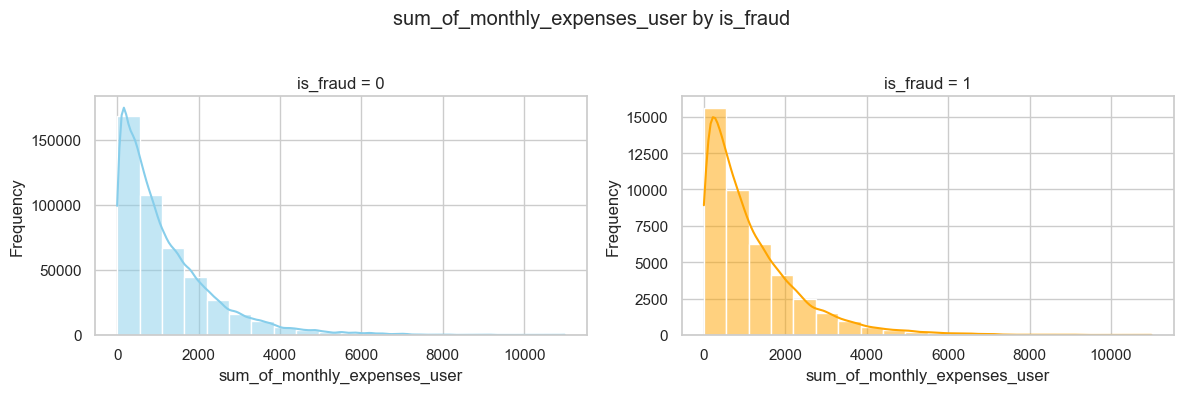

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,sum_of_monthly_expenses_user,continuous,1182.80,824.80,1169.78
1,sum_of_monthly_expenses_user,continuous,1177.49,828.02,1160.14


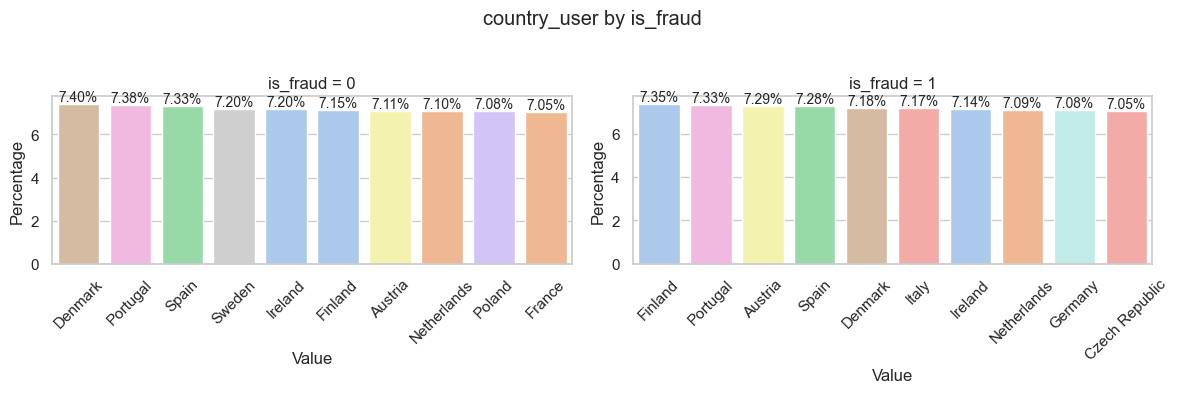

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,country_user,discrete,Denmark,7.40
1,country_user,discrete,Finland,7.35


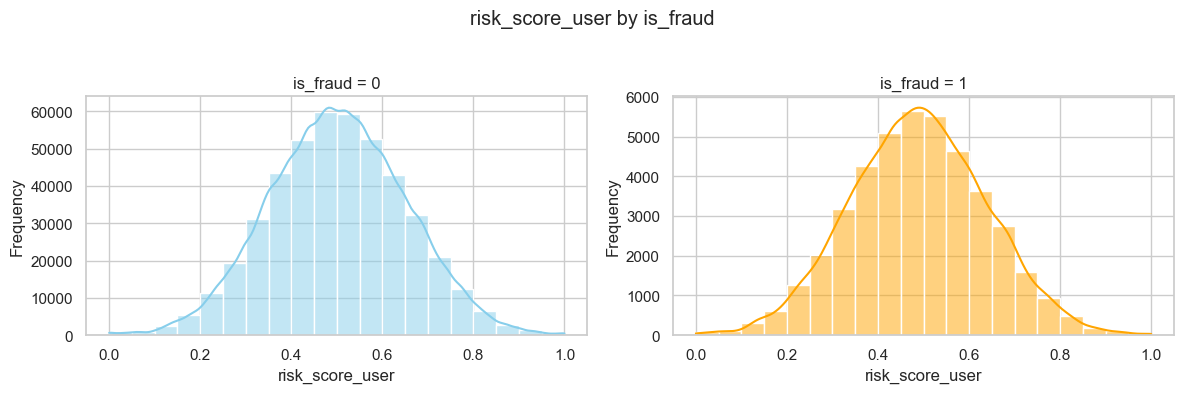

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,risk_score_user,continuous,0.50,0.50,0.15
1,risk_score_user,continuous,0.49,0.49,0.15


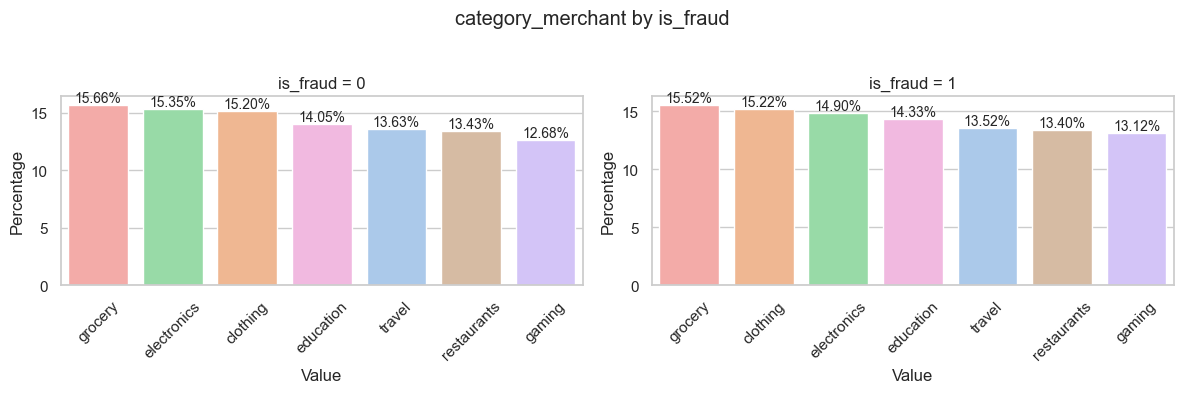

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,category_merchant,discrete,grocery,15.66
1,category_merchant,discrete,grocery,15.52


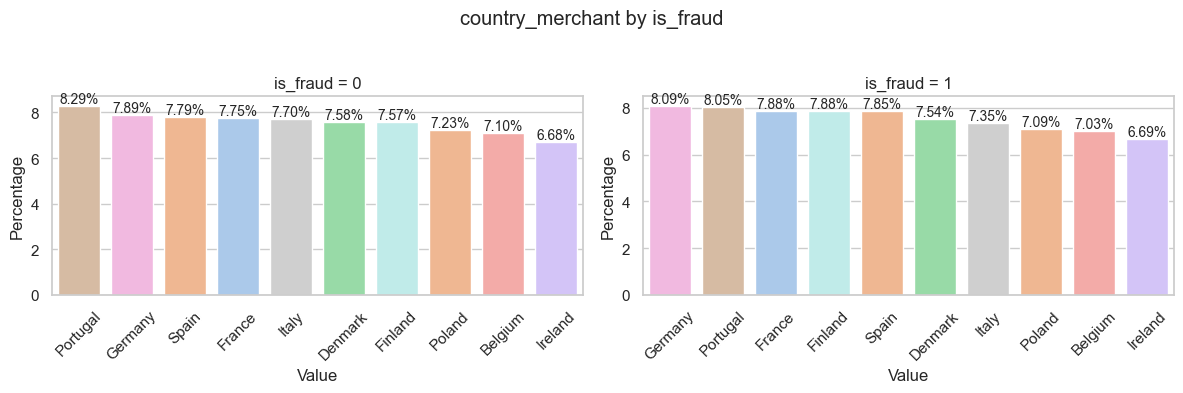

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,country_merchant,discrete,Portugal,8.29
1,country_merchant,discrete,Germany,8.09


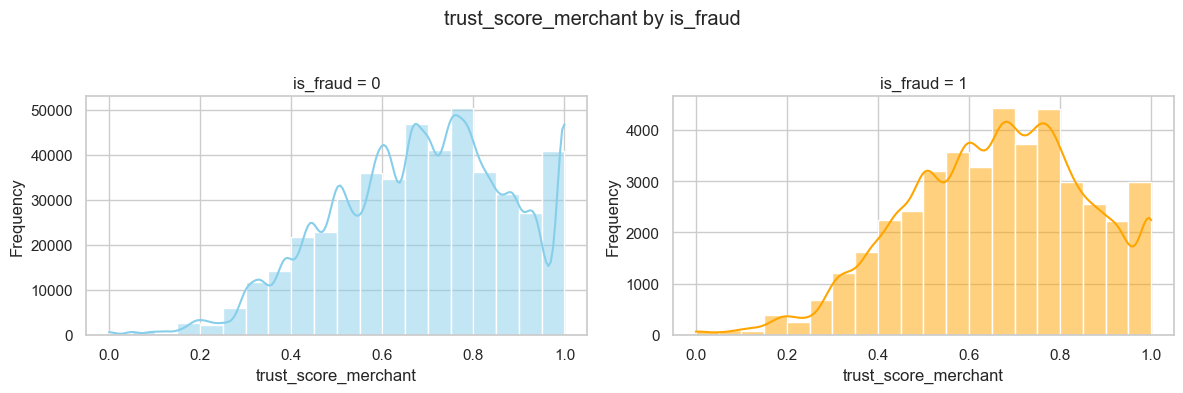

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,trust_score_merchant,continuous,0.68,0.70,0.19
1,trust_score_merchant,continuous,0.66,0.67,0.20


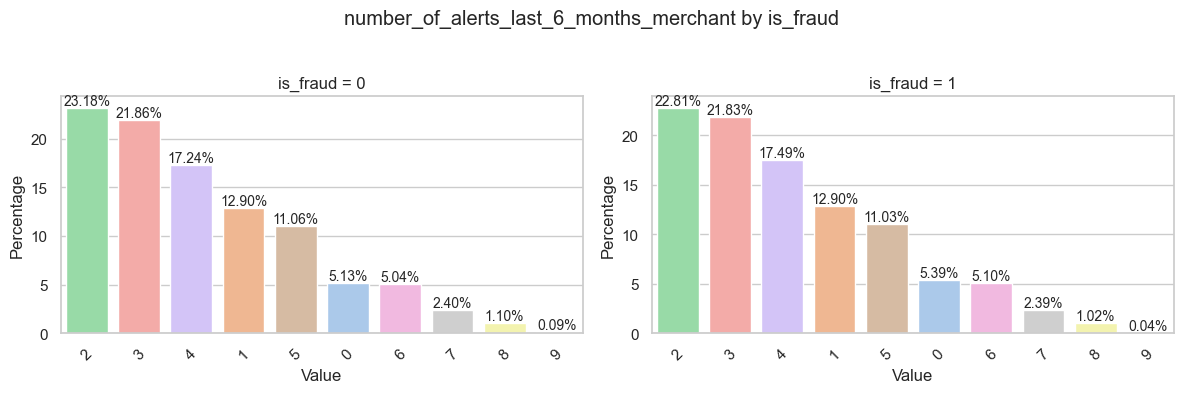

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,number_of_alerts_last_6_months_merchant,discrete,2,23.18
1,number_of_alerts_last_6_months_merchant,discrete,2,22.81


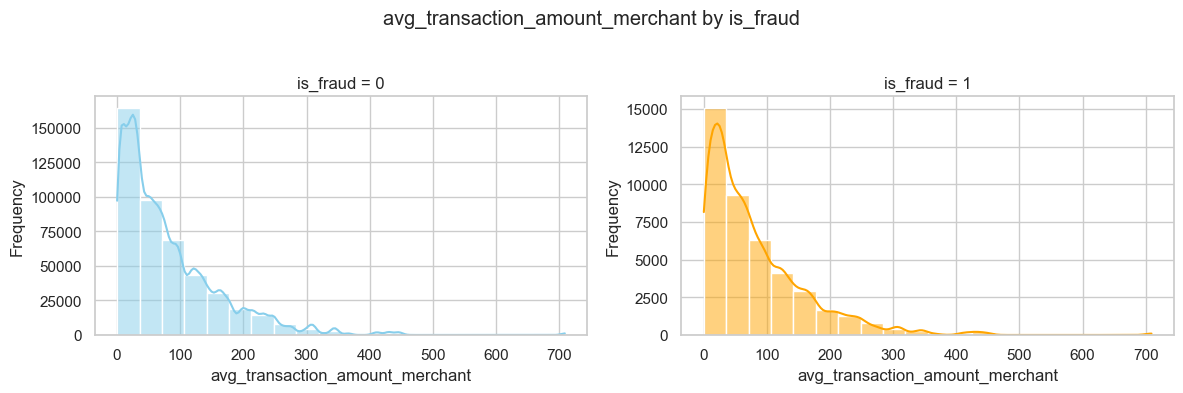

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,avg_transaction_amount_merchant,continuous,81.82,58.29,79.04
1,avg_transaction_amount_merchant,continuous,82.14,58.84,80.21


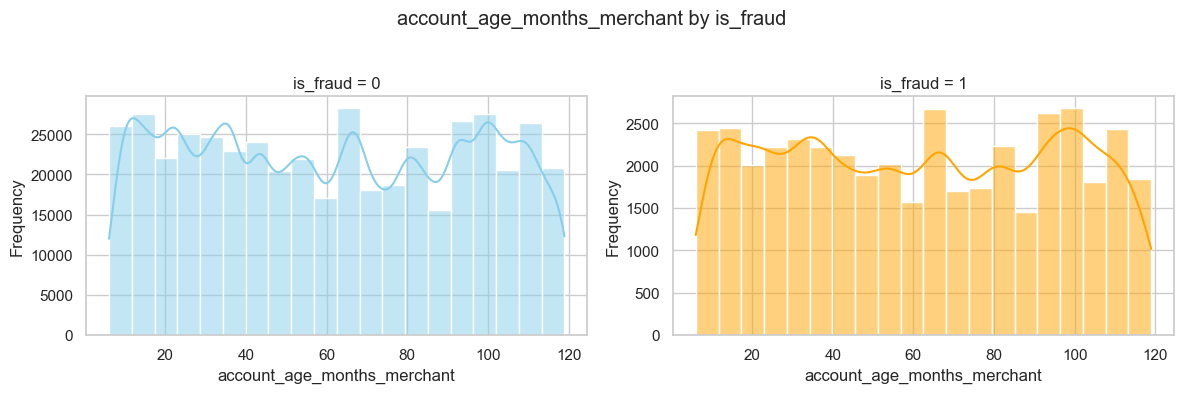

,Column,Type,Mean,Median,Std
Fraud,,,,,
0,account_age_months_merchant,continuous,61.53,61.0,33.44
1,account_age_months_merchant,continuous,61.78,62.0,33.30


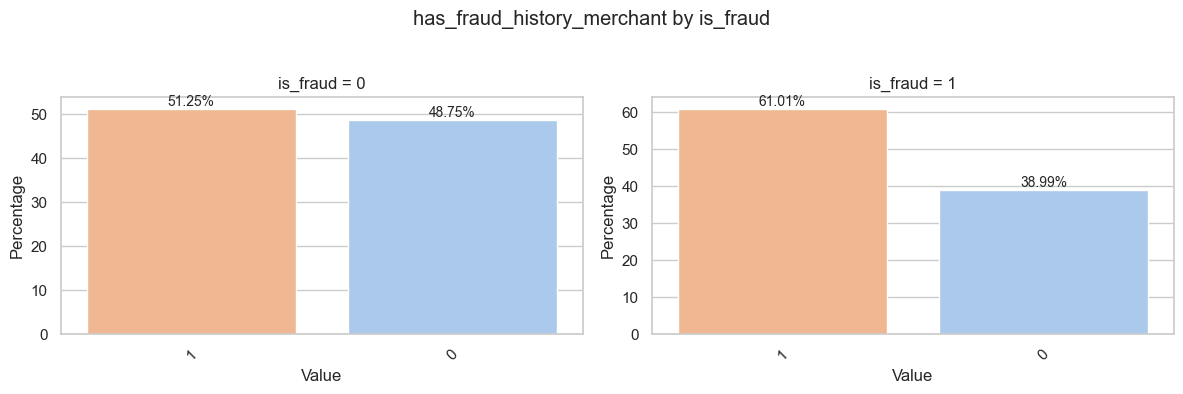

,Column,Type,Most frequent value,Percentage
Fraud,,,,
0,has_fraud_history_merchant,discrete,1,51.25
1,has_fraud_history_merchant,discrete,1,61.01


In [39]:
# Sample dataframe and exclude list (replace these with your own)
# df = pd.read_csv("your_data.csv")
exclude_columns_list = ['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'currency', 'signup_date_user', 'is_fraud']  # example

# Set plotting style
sns.set(style="whitegrid")

# Group by is_fraud
fraud_groups = {
    0: df_full.filter(pl.col("is_fraud") == 0),
    1: df_full.filter(pl.col("is_fraud") == 1)
}

# Store all results here
all_stats = []

for col in df_full.columns:
    if col in exclude_columns_list:
        continue

    # Get data type from any group
    sample_dtype = df_full[col].dtype

    is_continuous = sample_dtype in [pl.Float32, pl.Float64, pl.Int32, pl.Int64] and df_full[col].n_unique() > 20
    col_type = "continuous" if is_continuous else "discrete"

    df_display = pd.DataFrame()
    row_stats = pd.DataFrame({'Column': [col], 'Type': [col_type]})

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{col} by is_fraud")

    unique_labels = df_full.select(col).unique().sort(by=col)[col].cast(str).to_list()
    base_colors = sns.color_palette('pastel', len(unique_labels))
    palette_dict = dict(zip(unique_labels, base_colors))

    for i, fraud_flag in enumerate([0, 1]):
        group_df = fraud_groups[fraud_flag]

        try:
            data = group_df[col].drop_nulls().to_list()
        except Exception as e:
            print(f"Error in column {col} for is_fraud={fraud_flag}: {e}")
            continue

        total = len(data)
        if total == 0:
            continue

        if col_type == "continuous":
            arr = np.array(data)
            mean = round(np.mean(arr), 2)
            median = round(np.median(arr), 2)
            std = round(np.std(arr), 2)

            row_stats['Fraud'] = [fraud_flag]
            row_stats['Mean'] = [mean]
            row_stats['Median'] = [median]
            row_stats['Std'] = [std]

            sns.histplot(arr, bins=20, kde=True, ax=axes[i], color='skyblue' if fraud_flag == 0 else 'orange')
            axes[i].set_title(f"is_fraud = {fraud_flag}")
            axes[i].set_xlabel(col)
            axes[i].set_ylabel("Frequency")

        else:
            counts = Counter(data)
            top_value, top_count = counts.most_common(1)[0]
            top_percentage = round(top_count / total * 100, 2)

            row_stats['Fraud'] = [fraud_flag]
            row_stats['Most frequent value'] = [top_value]
            row_stats['Percentage'] = [top_percentage]

            top_items = counts.most_common(10)
            labels = [str(k) for k, _ in top_items]
            percentages = [v / total * 100 for _, v in top_items]

            ax = sns.barplot(x=labels, y=percentages, ax=axes[i], hue=labels, palette=palette_dict, legend=False)
            for container in ax.containers:
                ax.bar_label(container, labels=[f'{v.get_height():.2f}%' for v in container], fontsize=10)

            axes[i].set_title(f"is_fraud = {fraud_flag}")
            axes[i].set_xlabel("Value")
            axes[i].set_ylabel("Percentage")
            axes[i].tick_params(axis='x', rotation=45)
        
        df_display = pd.concat([df_display, row_stats])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    df_display.set_index('Fraud', inplace=True)
    display(df_display)

In [42]:
np.set_printoptions(legacy='1.25')

# Split data by is_fraud
fraud_df = df_full.filter(pl.col("is_fraud") == 1)
nonfraud_df = df_full.filter(pl.col("is_fraud") == 0)

results = {}

for col in df_full.columns:
    if col in exclude_columns_list:
        continue

    col_dtype = df_full.schema[col]

    if col_dtype in [pl.Float64, pl.Int64, pl.Float32, pl.Int32]:
        # Numerical: extract as numpy arrays
        fraud_vals = fraud_df.select(col).to_numpy().flatten()
        nonfraud_vals = nonfraud_df.select(col).to_numpy().flatten()

        try:
            stat, p = ttest_ind(fraud_vals, nonfraud_vals, equal_var=False, nan_policy='omit')
            results[col] = {"test": "t-test", "p_value": round(p, 5)}
        except Exception as e:
            results[col] = {"test": "t-test", "error": str(e)}

    else:
        # Categorical: use chi-square test
        try:
            contingency = (
                df_full.select([col, "is_fraud"])
                .to_pandas()
                .groupby([col, "is_fraud"])
                .size()
                .unstack(fill_value=0)
            )
            chi2, p, _, _ = chi2_contingency(contingency)
            results[col] = {"test": "chi2", "p_value": round(p, 5)}
        except Exception as e:
            results[col] = {"test": "chi2", "error": str(e)}

# Show significant results
significant = {k: v for k, v in results.items() if v.get("p_value", 1) < 0.05}
print("Significantly different columns between is_fraud = 0 and 1:")
for col, res in significant.items():
    print(f"{col}: {res}")

Significantly different columns between is_fraud = 0 and 1:
is_international: {'test': 't-test', 'p_value': 0.0}
risk_score_user: {'test': 't-test', 'p_value': 0.0}
category_merchant: {'test': 'chi2', 'p_value': 0.02799}
country_merchant: {'test': 'chi2', 'p_value': 0.00639}
trust_score_merchant: {'test': 't-test', 'p_value': 0.0}
has_fraud_history_merchant: {'test': 't-test', 'p_value': 0.0}
